In [248]:
import os
import shutil

if os.path.exists(oasis1_path):
    shutil.rmtree(oasis1_path)
    print(f"Cartella eliminata con successo.")
else:
    print(f"La cartella non esiste o non è una directory.")


Cartella eliminata con successo.


In [249]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **SUL DATASET**

Il dataset è una versione pre-processata del dataset **OASIS Alzheimer's Detection** (un dataset di immagini MRI del cervello di 461 pazienti) utilizzato per rilevare i segni precoci dell’Alzheimer.

Poiché le immagini MRI sono 3D, sono state divise lungo l'asse z (l'asse della profondità del cervello) in 175 fette e sono state selezionate le fette che vanno dalla 55 esima alla 124 esima al fine di ridurre il numero di immagini e concentrarsi sulle sezioni cerebrali rilevanti per l'analisi della demenza; Questo approccio ha generato immagini 2D per ogni paziente.

Lo stesso approccio è stato utilizzato per le versioni delle MRI con segmentazione delle aree cerebrali offerte da OASIS effettuate tramite FSL FAST.

****
****

Le immagini sono classificate in **quattro sottoclassi**, in base alla progressione della malattia:

*   Moderate dementia (affetto da demenza)

*   Very mild dementia (affetto da demenza molto lieve)
* Mild dementia (affetto da demenza lieve)
* Non-demented (non affetto da demenza)


*La classificazione dei pazienti è stata effettuata sulla base delle valutazioni CDR (Clinical Dementia Rating), un punteggio che valuta la severità della demenza.*



In [250]:
# Import

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import zipfile
import os
import matplotlib.patches as mpatches
import numpy as np
from PIL import Image
import math
import shutil

In [251]:
# Estrazione dataset

zip_path = "/content/drive/My Drive/Alzheimer-detection-project/oasis 1.zip"
extract_folder = "/content/Alzheimer-detection-project"

os.makedirs(extract_folder, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print("File estratti:", os.listdir(extract_folder))


File estratti: ['__MACOSX', 'oasis 1']


In [252]:
oasis1_path = os.path.join(extract_folder, "oasis 1")
categories = ['Moderate Dementia', 'Mild Dementia', 'Very Mild Dementia', 'Non Demented']
for category in categories:
    category_path = os.path.join(oasis1_path, category)
    mri_segmented_path=os.path.join(category_path, 'mri segmented')
    mri_path= os.path.join(category_path, 'mri scan')

In [253]:
# Rimozione files inutili
for dirpath, dirnames, filenames in os.walk(oasis1_path):
    for filename in filenames:
        if filename == ".DS_Store":
            file_path = os.path.join(dirpath, filename)
            os.remove(file_path)
            print(f"Rimosso: {file_path}")


Rimosso: /content/Alzheimer-detection-project/oasis 1/.DS_Store
Rimosso: /content/Alzheimer-detection-project/oasis 1/Very Mild Dementia/.DS_Store
Rimosso: /content/Alzheimer-detection-project/oasis 1/Very Mild Dementia/mri segmented/.DS_Store
Rimosso: /content/Alzheimer-detection-project/oasis 1/Very Mild Dementia/mri scan/.DS_Store
Rimosso: /content/Alzheimer-detection-project/oasis 1/Moderate Dementia/.DS_Store
Rimosso: /content/Alzheimer-detection-project/oasis 1/Moderate Dementia/mri segmented/.DS_Store
Rimosso: /content/Alzheimer-detection-project/oasis 1/Moderate Dementia/mri scan/.DS_Store
Rimosso: /content/Alzheimer-detection-project/oasis 1/Non Demented/.DS_Store
Rimosso: /content/Alzheimer-detection-project/oasis 1/Non Demented/mri segmented/.DS_Store
Rimosso: /content/Alzheimer-detection-project/oasis 1/Non Demented/mri segmented/OAS1_0001MR1 seg/.DS_Store
Rimosso: /content/Alzheimer-detection-project/oasis 1/Non Demented/mri segmented/OAS1_0002MR1 seg/.DS_Store
Rimosso: /c

numero foto Moderate Dementia: 140
numero foto Mild Dementia: 1960
numero foto Very Mild Dementia: 5006
numero foto Non Demented: 23520


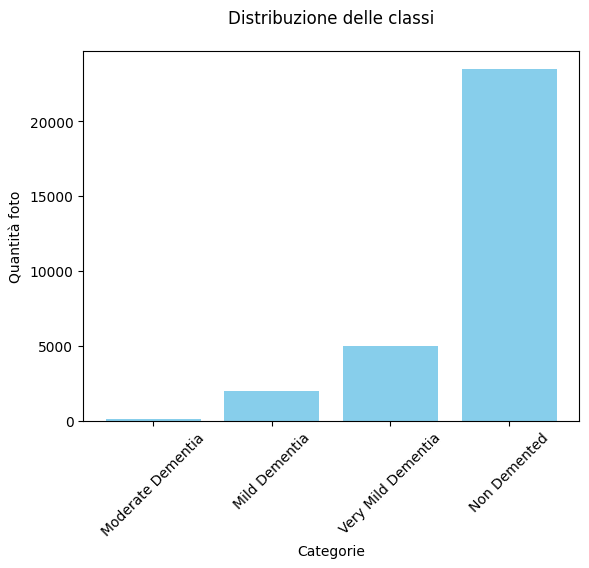

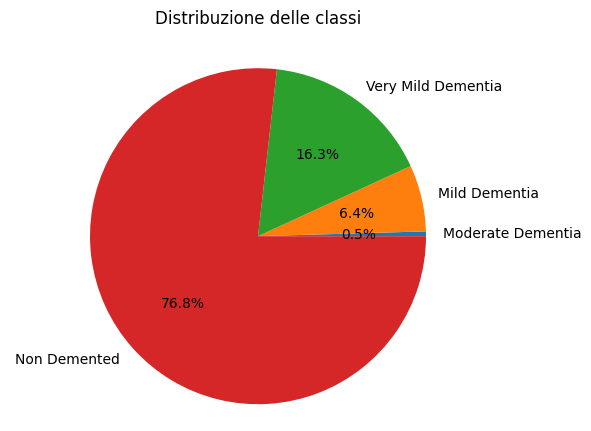

In [254]:
# Numero di immagini per categoria - grafico di distribuzione delle classi

somma=0

for category in categories:
    category_path = os.path.join(oasis1_path, category)
    mri_segmented_path=os.path.join(category_path, 'mri segmented')
    for patient in os.listdir(mri_segmented_path):
      images= os.listdir(os.path.join(mri_segmented_path, patient))
      somma=somma+len(images)
    somma=0

valori=[]

for category in categories:
    category_path = os.path.join(oasis1_path, category)
    mri_path= os.path.join(category_path, 'mri scan')
    for patient in os.listdir(mri_path):
      images= os.listdir(os.path.join(mri_path, patient))
      somma=somma+len(images)
    print(f'numero foto {category}: {somma}')
    valori.append(somma)
    somma=0

# Visualizzazione tramite istogramma
plt.bar(categories, valori, color='skyblue')
plt.title('Distribuzione delle classi', pad=20)
plt.xlabel('Categorie')
plt.xticks(rotation=45)
plt.ylabel('Quantità foto')
plt.show()
print(f" ")

# Visualizzazione tramite grafico a torta
plt.pie(valori, labels=categories, autopct='%1.1f%%', startangle=0)
plt.title('Distribuzione delle classi',pad=20)
plt.axis('equal')
plt.show()




Il dataset è estremamente sbilanciato.

### APPROCCI ADOTTATI PER AFFRONTARE IL PROBLEMA DELLO SBILANCIAMENTO:

- **Unione delle due classi minoritarie** (Mild Dementia e Moderate Demenntia) dato che il focus del progetto è una early detection dell'alzheimer.
- **Downsampling parziale della classe maggioritaria** (Non Demented) per limitare il rischio di bias.
- **Bilanciamento delle classi tramiti pesi** (class weights) durante la fase di addestramento per compensare le differenze residue.

In [255]:
# Sposto i files da Moderate dementia in Mild Dementia
mod_d_path=os.path.join(oasis1_path, "Moderate Dementia")
mild_d_path=os.path.join(oasis1_path, "Mild Dementia")
source_path=os.path.join(mod_d_path, "mri scan")
dest_path=os.path.join(mild_d_path, "mri scan")

for folder in os.listdir(source_path):
  source_file=os.path.join(source_path, folder)
  shutil.move(source_file, dest_path)

source_path=os.path.join(mod_d_path, "mri segmented")
dest_path=os.path.join(mild_d_path, "mri segmented")
for folder in os.listdir(source_path):
  source_file=os.path.join(source_path, folder)
  shutil.move(source_file, dest_path)


In [256]:
# Rinomino la cartella
mild_to_mod_path= os.path.join(oasis1_path, "Mild to Moderate Dementia")
if os.path.exists(mild_d_path):
    os.rename(mild_d_path, mild_to_mod_path)
    print("Cartella rinominata con successo.")
else:
    print("La cartella di origine non esiste.")


categories = ['Mild to Moderate Dementia', 'Very Mild Dementia', 'Non Demented']

Cartella rinominata con successo.


In [257]:
# Elimino la cartella vuota
cartella_da_eliminare = os.path.join(oasis1_path, "Moderate Dementia")
shutil.rmtree(cartella_da_eliminare)


In [258]:
# Downsampling della classe maggioritaria
nd_path=os.path.join(oasis1_path, "Non Demented")
mri_path=os.path.join(nd_path, "mri scan")
mri_seg_path=os.path.join(nd_path, "mri segmented")

n=180
folders=os.listdir(mri_path)
to_delete=random.sample(folders, n)

for folder in to_delete:
  folder_seg= f"{folder.strip()} seg"
  path=os.path.join(mri_path, folder)
  path_seg=os.path.join(mri_seg_path, folder_seg)
  shutil.rmtree(path)
  shutil.rmtree(path_seg)

numero foto Mild to Moderate Dementia: 2100
numero foto Very Mild Dementia: 5006
numero foto Non Demented: 10920


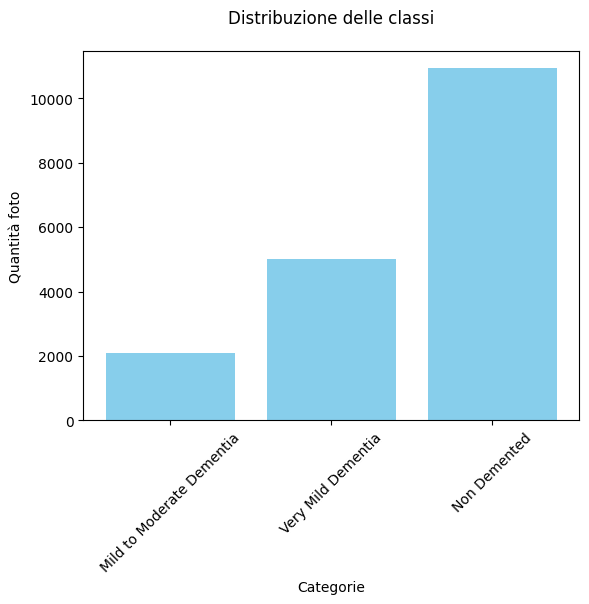

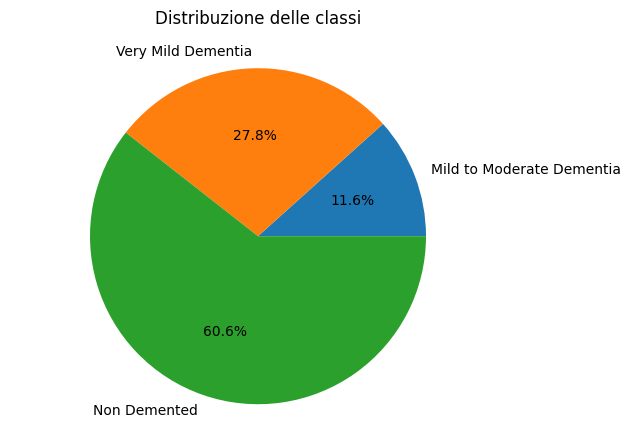

In [259]:
# Numero di immagini per categoria - grafico di distribuzione delle classi
#dopo unione delle cartelle e downsampling

somma=0

for category in categories:
    category_path = os.path.join(oasis1_path, category)
    mri_segmented_path=os.path.join(category_path, 'mri segmented')
    for patient in os.listdir(mri_segmented_path):
      images= os.listdir(os.path.join(mri_segmented_path, patient))
      somma=somma+len(images)
    somma=0

valori=[]

for category in categories:
    category_path = os.path.join(oasis1_path, category)
    mri_path= os.path.join(category_path, 'mri scan')
    for patient in os.listdir(mri_path):
      images= os.listdir(os.path.join(mri_path, patient))
      somma=somma+len(images)
    print(f'numero foto {category}: {somma}')
    valori.append(somma)
    somma=0

# Visualizzazione tramite istogramma
plt.bar(categories, valori, color='skyblue')
plt.title('Distribuzione delle classi', pad=20)
plt.xlabel('Categorie')
plt.xticks(rotation=45)
plt.ylabel('Quantità foto')
plt.show()
print(f" ")

# Visualizzazione tramite grafico a torta
plt.pie(valori, labels=categories, autopct='%1.1f%%', startangle=0)
plt.title('Distribuzione delle classi',pad=20)
plt.axis('equal')
plt.show()

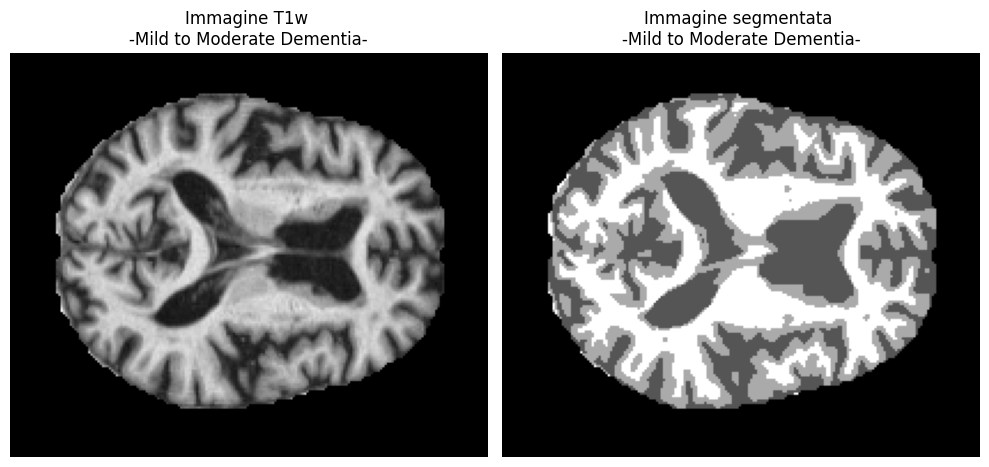

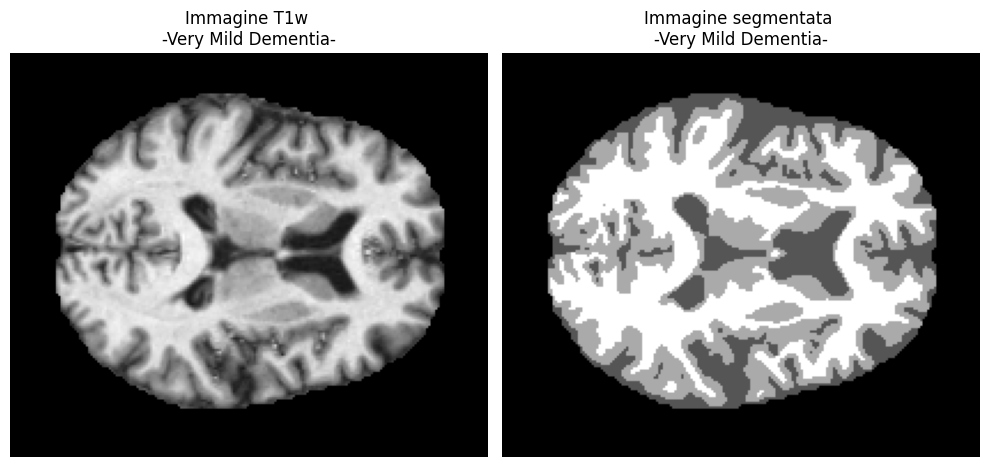

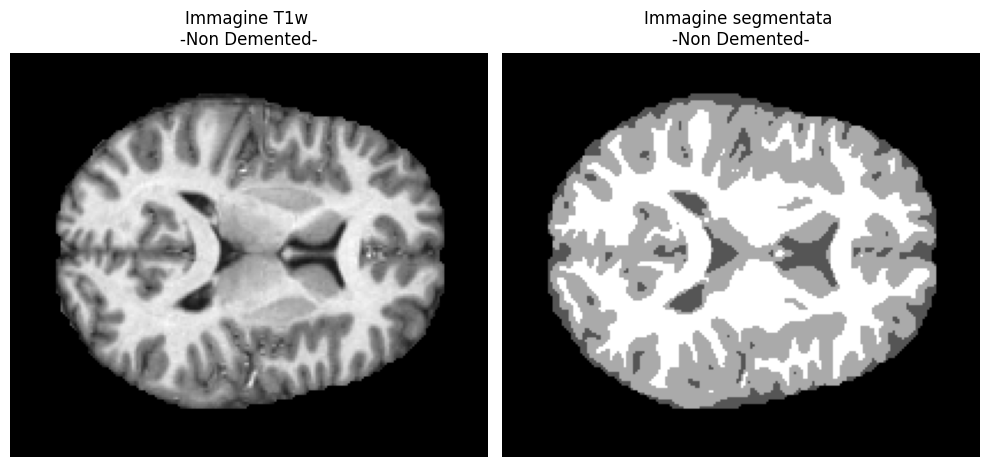

In [260]:
#VISUALIZZAZIONE DI IMMAGINI A CAMPIONE

# Scelta randomica della slice

#folders=os.listdir(mri_path)
#random_folder = random.choice(folders)
#patient_path= os.path.join(mri_path, random_folder)
#random_slice = random.choice(os.listdir(patient_path))

# Stampa di un immagine segmentata e un immagine T1w per categoria
for category in categories:
  category_path = os.path.join(oasis1_path, category)
  mri_segmented_path=os.path.join(category_path, 'mri segmented')
  mri_path= os.path.join(category_path, 'mri scan')
  folders=os.listdir(mri_path)
  random_folder = random.choice(folders)
  random_folder_seg= f"{random_folder.strip()} seg"

  patient_path= os.path.join(mri_path, random_folder)
  patient_path_seg= os.path.join(mri_segmented_path, random_folder_seg)

  img_path = os.path.join(patient_path, 'slice_85.png')
  img = mpimg.imread(img_path)
  img_seg_path = os.path.join(patient_path_seg, 'slice_85.png')
  img_seg = mpimg.imread(img_seg_path)

  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  axes[0].imshow(img)
  axes[0].set_title(f"Immagine T1w \n-{category}-")
  axes[0].axis('off')

  axes[1].imshow(img_seg)
  axes[1].set_title(f"Immagine segmentata \n-{category}-")
  axes[1].axis('off')

  plt.tight_layout()
  plt.show()




4 valori differenti: [0.         0.33333334 0.6666667  1.        ]




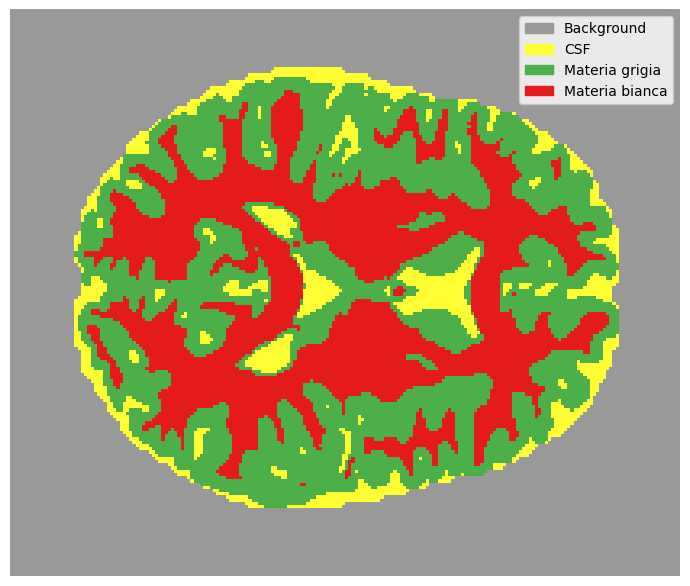

In [261]:
# Visualizzazione con etichette delle immagini segmentate

# Scelta di un immagine segmentata (parte commentata per randomizzazione)

#category='Very Mild Dementia'
#category_path = os.path.join(oasis1_path, category)
#mri_segmented_path = os.path.join(category_path, 'mri segmented')
#folders = os.listdir(mri_segmented_path)
#random_folder = random.choice(folders)
#patient_path = os.path.join(mri_segmented_path, random_folder)
#random_slice = random.choice(os.listdir(patient_path))
#img_seg_path = os.path.join(patient_path, random_slice)

img_seg = mpimg.imread(img_seg_path)
img_seg = img_seg[:, :, 0]

labels=['Background', 'CSF', 'Materia grigia', 'Materia bianca']
valori_unici = np.unique(img_seg)
print(f"{len(valori_unici)} valori differenti: {valori_unici}\n\n")

# creazione della leggenda e visualizzazione
cmap = plt.cm.Set1_r
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img_seg, cmap=cmap)

patches = []
for i, val in enumerate(valori_unici):
  patch = mpatches.Patch(color=cmap(val), label=labels[i])
  patches.append(patch)
ax.legend(handles=patches, loc='upper right')

ax.axis('off')
plt.tight_layout()
plt.show()

I valori dell'output segmentato sono normalizzati e lo standard è:

| Valore         | Etichetta         |  
|----------------|-------------------|
| `0.0`          | **Background**     |
| `0.33333334`   | **CSF**            |
| `0.6666667`    | **Materia Grigia** |
| `1.0`          | **Materia Bianca** |

In [247]:
# Check dimensioni e canali

images_dimentions=set()
images_channels=set()

# Per ognni immagine in ogni categoria salva dimensioni e numero di canale negli insiemi
for category in categories:
    category_path = os.path.join(oasis1_path, category)
    mri_path= os.path.join(category_path, 'mri scan')
    for patient in os.listdir(mri_path):
      patient_path=os.path.join(mri_path, patient)
      file_path=os.path.join(patient_path, '.DS_Store')
      if os.path.isfile(file_path):
        os.remove(file_path)
      images= os.listdir(os.path.join(mri_path, patient))

      for image in images:
        image_path=os.path.join(patient_path, image)
        i = mpimg.imread(image_path)
        w, h = i.shape[:2]
        images_dimentions.add((w, h))

        if len(i.shape) == 3:
          channels = i.shape[2]
        else:
          channels = 1
        images_channels.add(channels)

# Controllo del numero di elementi negli insiemi
if len(images_dimentions) == 1:
  print("tutte le immagini hanno le stesse dimensioni", images_dimentions.pop())
else:
  print("NON tutte le immagini hanno le stesse dimensioni:")
  for dim in images_dimentions:
        print(" ", dim)

if len(images_channels) == 1:
    print("tutte le immagini hanno lo stesso numero di canali:", images_channels.pop())
else:
    print("NON tutte le immagini hanno lo stesso numero di canali:")
    for ch in images_channels:
        print(" ", ch)



tutte le immagini hanno le stesse dimensioni (176, 208)
tutte le immagini hanno lo stesso numero di canali: 4


In [262]:
# Conversione delle immagini MRI in scale di grigi
# Utilizzo Grayscale = 0.299 * R + 0.587 * G + 0.114 * B

for category in categories:
    category_path = os.path.join(oasis1_path, category)
    mri_path= os.path.join(category_path, 'mri scan')
    for patient in os.listdir(mri_path):
        patient_path = os.path.join(mri_path, patient)
        file_path = os.path.join(patient_path, '.DS_Store')
        if os.path.isfile(file_path):
            os.remove(file_path)
        images = os.listdir(os.path.join(mri_path, patient))

        for image in images:
            image_path = os.path.join(patient_path, image)
            i = mpimg.imread(image_path)

            if len(i.shape) == 3 and i.shape[2] >= 3:
                i_rgb = i[..., :3]

                i_gray = 0.299 * i_rgb[..., 0] + 0.587 * i_rgb[..., 1] + 0.114 * i_rgb[..., 2]
                i_gray = (i_gray * 255).astype(np.uint8)
                gray_img = Image.fromarray(i_gray)
                gray_img.save(image_path)

# Check del nuovo numero di canali
images_channels=set()
for category in categories:
    category_path = os.path.join(oasis1_path, category)
    mri_path= os.path.join(category_path, 'mri scan')
    for patient in os.listdir(mri_path):
      patient_path=os.path.join(mri_path, patient)
      images= os.listdir(os.path.join(mri_path, patient))

      for image in images:
        image_path=os.path.join(patient_path, image)
        i = mpimg.imread(image_path)

        if len(i.shape) == 3:
          channels = i.shape[2]
        else:
          channels = 1
        images_channels.add(channels)

if len(images_channels) == 1:
    print("tutte le immagini hanno lo stesso numero di canali:", images_channels.pop())
else:
    print("NON tutte le immagini hanno lo stesso numero di canali:")
    for ch in images_channels:
        print(" ", ch)

tutte le immagini hanno lo stesso numero di canali: 1


In [263]:
# Calcolo della deviazione standard e mse

std_interclasse= {}
mse_interclasse={}
std_intraclasse={}
mse_intraclasse={}


selected_slices = ['slice_60.png', 'slice_85.png', 'slice_103.png', 'slice_120.png']  # Esempio: nomi delle slice

for name in selected_slices:  #for name in images per prendere tutte le immagini
  slices_all_categories = []
  for category in categories:
    slices = []
    category_path = os.path.join(oasis1_path, category)
    mri_path= os.path.join(category_path, 'mri scan')
    for patient in os.listdir(mri_path):
      patient_path=os.path.join(mri_path, patient)
      slice_of_interest= os.path.join(patient_path, name)
      i = Image.open(slice_of_interest)
      i_array = np.array(i)
      slices.append(i_array)

    if slices:
        slices_stack_interclasse = np.stack(slices)
        std_map_interclasse = np.std(slices_stack_interclasse, axis=0)
        mean_slice_interclasse = np.mean(slices_stack_interclasse, axis=0)
        mse_map_interclasse = np.mean((slices_stack_interclasse - mean_slice_interclasse) ** 2, axis=0)
        mse_interclasse[(name,category)] = mse_map_interclasse
        std_interclasse[(name, category)] = std_map_interclasse

        slices_all_categories.extend(slices)

  if slices_all_categories:
        slices_stack_intraclasse = np.stack(slices_all_categories)
        std_map_intraclasse = np.std(slices_stack_intraclasse, axis=0)
        mean_slice_intraclasse = np.mean(slices_stack_intraclasse, axis=0)
        mse_map_intraclasse = np.mean((slices_stack_intraclasse - mean_slice_intraclasse) ** 2, axis=0)
        std_intraclasse[name] = std_map_intraclasse
        mse_intraclasse[name] = mse_map_intraclasse





### **DEVIAZIONE STANDARD --> misura dove variano di più i pixel**

- STD ALTA: molta variabilità nei valori dei pixel

- STD BASSA: poca variabilità nei valori dei pixel

### **MEAN SQUARE ERROR --> misura quanto ogni pixel si allontana dalla media**

- MSE ALTO: alta variabilità intra-classe

- MSE BASSO: bassa variabilità intra-classe

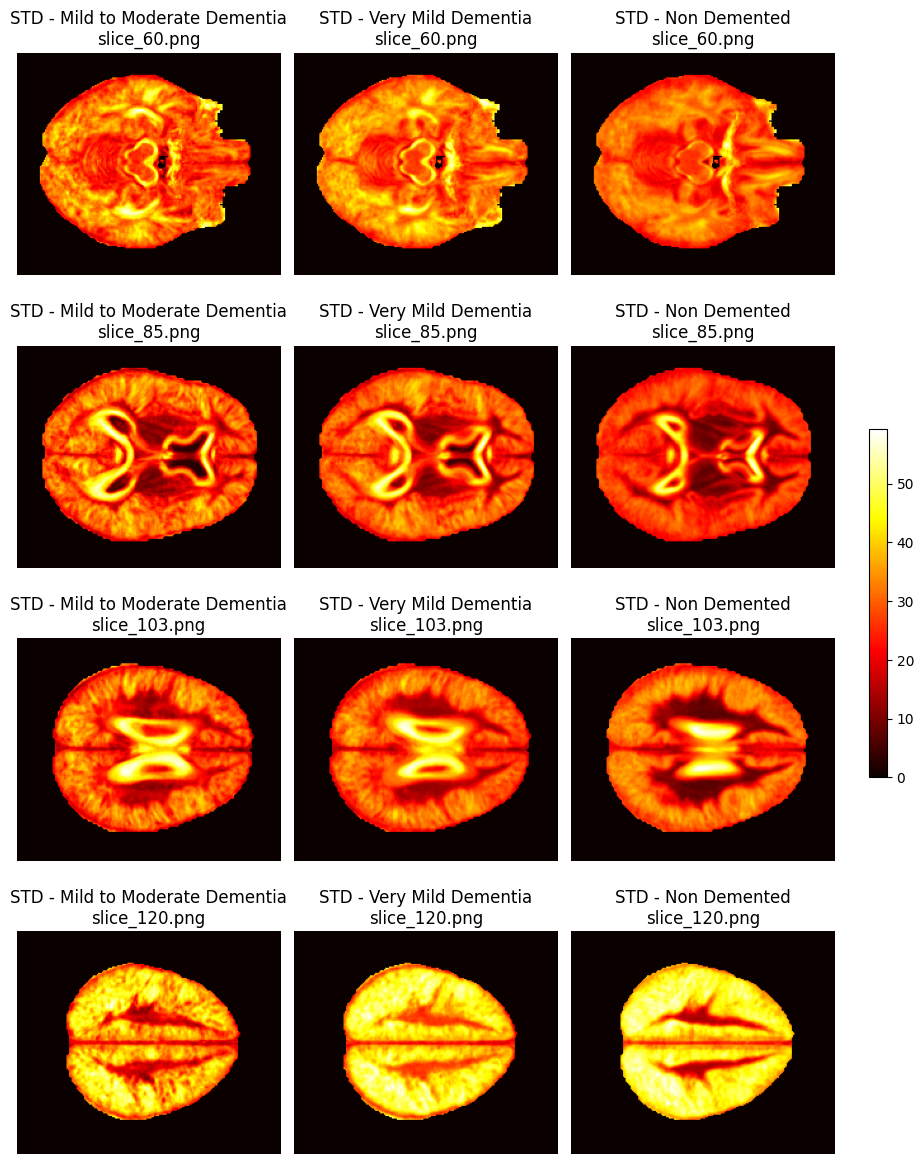

In [264]:
#  Visualizzazione della deviazione standard (sulla stessa slice) intra classe

columns = 3
imgs = len(std_interclasse)
rows = math.ceil(imgs / columns)
plt.figure(figsize=(columns * 3, rows * 3))

for idx, ((name, category), std_map_interclasse) in enumerate((std_interclasse.items())):
    plt.subplot(rows, columns, idx + 1)
    im = plt.imshow(std_map_interclasse, cmap='hot')
    plt.title(f"STD - {category}\n{name}")
    plt.axis('off')

plt.tight_layout()
plt.colorbar(im, ax=plt.gcf().get_axes(), fraction=0.02, pad=0.04)
plt.show()

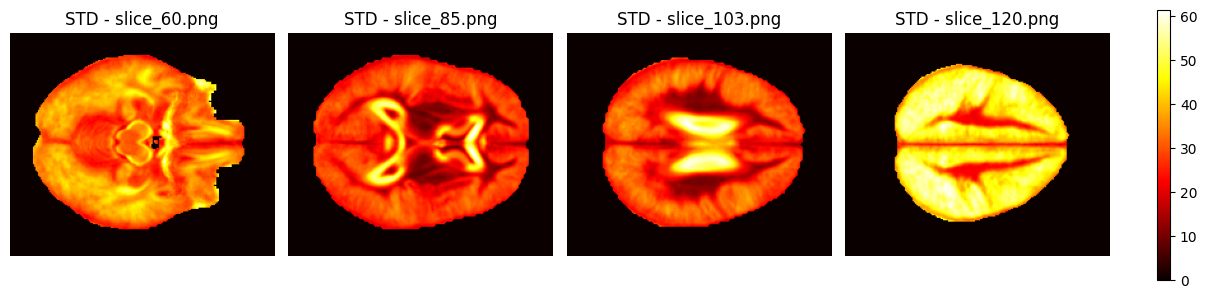

In [265]:
# Visualizzazione della deviazione standard (sulla stessa slice) inter classe

columns = 4
imgs = len(std_intraclasse)
rows = math.ceil(imgs / columns)
plt.figure(figsize=(columns * 3, rows * 3))

for idx, (name, std_map_intraclasse) in enumerate(std_intraclasse.items()):
    plt.subplot(rows, columns, idx + 1)
    im = plt.imshow(std_map_intraclasse, cmap='hot')
    plt.title(f"STD - {name}")
    plt.axis('off')

plt.tight_layout()
plt.colorbar(im, ax=plt.gcf().get_axes(), fraction=0.02, pad=0.04)
plt.show()

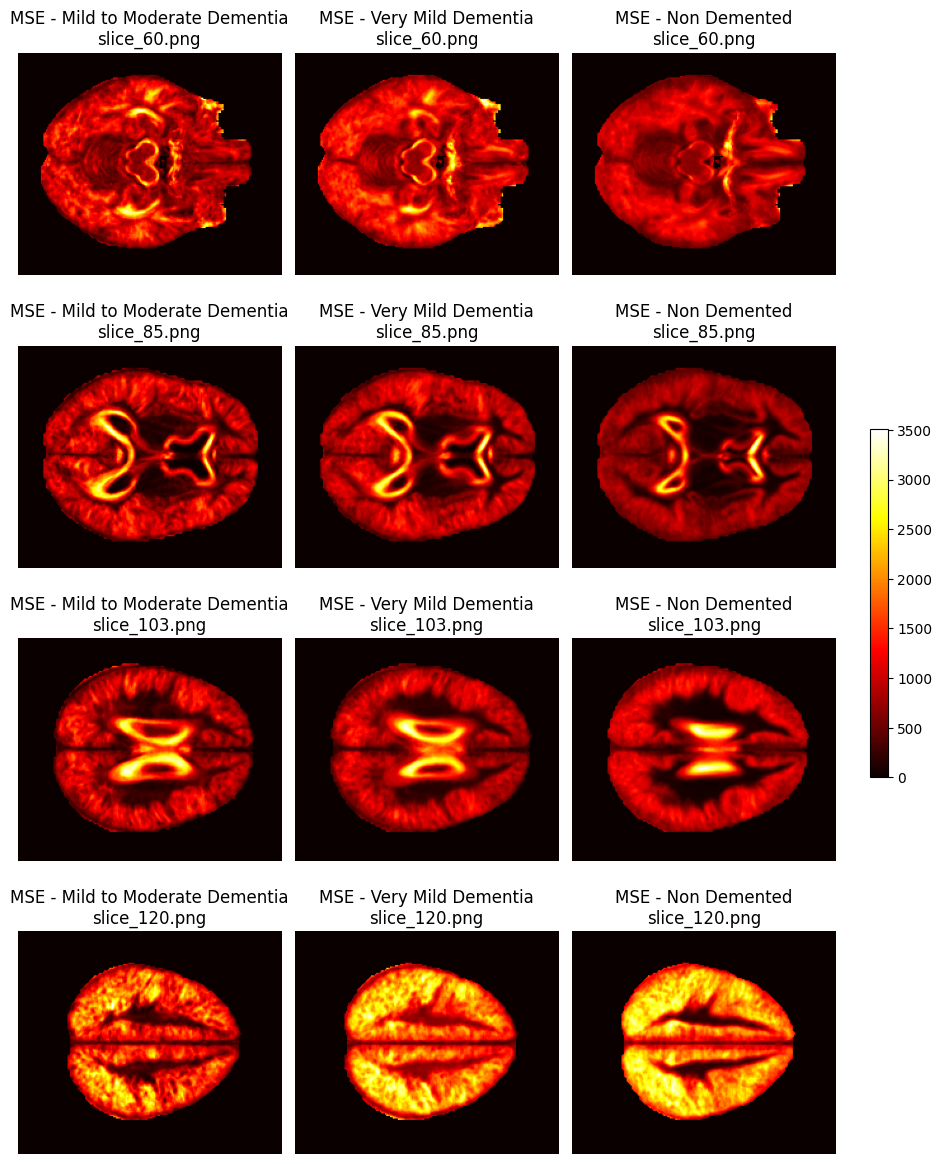

In [266]:
# Visualizzazione dell'MSE (sulla stessa slice) intra classe

columns = 3
imgs = len(mse_interclasse)
rows = math.ceil(imgs / columns)
plt.figure(figsize=(columns * 3, rows * 3))

for idx, ((name, category), mse_map_interclasse) in enumerate(mse_interclasse.items()):
    plt.subplot(rows, columns, idx + 1)
    im = plt.imshow(mse_map_interclasse, cmap='hot')
    plt.title(f"MSE - {category}\n{name}")
    plt.axis('off')

plt.tight_layout()
plt.colorbar(im, ax=plt.gcf().get_axes(), fraction=0.02, pad=0.04)
plt.show()

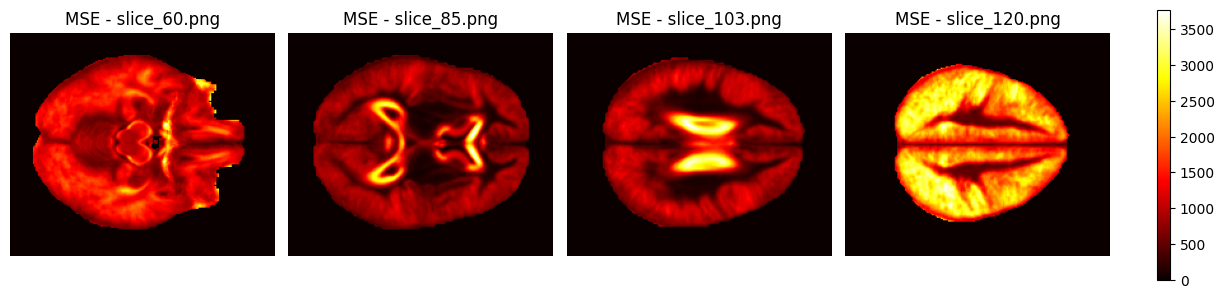

In [267]:
# Visualizzazione dell'MSE (sulla stessa slice) inter classe

columns = 4
imgs = len(mse_intraclasse)
rows = math.ceil(imgs / columns)
plt.figure(figsize=(columns * 3, rows * 3))

for idx, (name, mse_map_intraclasse) in enumerate(mse_intraclasse.items()):
    plt.subplot(rows, columns, idx + 1)
    im = plt.imshow(mse_map_intraclasse, cmap='hot')
    plt.title(f"MSE - {name}")
    plt.axis('off')

plt.tight_layout()
plt.colorbar(im, ax=plt.gcf().get_axes(), fraction=0.02, pad=0.04)
plt.show()

In [268]:
# divisione in test, training e validation set